# The introductory computer exercise using Python and the SUND toolbox

This version of the exercise is implemented as a Python version using the SUND toolbox, running in an iPython notebook. The notebook can either be [run online in Google colab](https://colab.research.google.com/drive/1y37yYcxwSj5yd0yUePGxtvXZhJNkxf_-?usp=sharing), or <a href="https://isbgroup.eu/edu/courses/intro/computer_exercise/python_sund.ipynb" download>downloaded</a> and run locally.

Note: if running in Google colab, your downloaded and created files will be deleted after you close the session. If you decide to use it, make sure that you download backups! Furthermore, the first thing you should do is to save a copy of the notebook. To do this, press `File > Save a copy in Drive`.

## Introduction

### Purpose of the lab

This lab will on a conceptual level guide you through all the main sub-tasks in a systems biology project: model creation, model training using experimental data, model evaluation, and finally using the model to make predictions of new experiments.

This is an example of the steps the students should do in the exercise, but here implemented in Python. Step 0 revolves around setting up the environment, which will of course be very different when running in system modeller. In this example, I will lump together quite a lot of steps since they will most likely be completely different in the system modeller implementation

## Step 0: Setting up the environment

<details class="admonition success"><summary> Setting up the simulation toolbox</summary>

First make sure that you have a c-compiler installed. If you are running a unix-based operating system such as Mac OS or Linux you will have c-compiler already installed.

For Windows users you will need to install a c-compiler, for the newer Python distribution (version > 3.4) you will need to install the Microsoft Visual C++ compiler (MSVC). This can either be installed as a part of Visual Studios or as a standalone installation using Visual Studios Build Tools. [Here](https://wiki.python.org/moin/WindowsCompiler) can you see which compiler you need for your Python installations and follow the links to install the compiler.

Make sure you have pip (the Python package installer) installed: From the terminal (Unix-users) or command window (Windows-users) try running `pip --version` (Linux users may have to write `pip3`). If `pip` is not installed, follow instructions [here](https://packaging.python.org/tutorials/installing-packages/) to install it.

When you have ensured that pip is installed, check that setuptools and wheel are installed by running `pip show setuptools`. If installed it should show information about the setuptools package, such as version number. If not installed you can install it using pip: `pip install wheel setuptools`.

After that you also need to install `numpy`, `matplotlib`, `jupyter` and the [`SUND toolbox`](https://isbgroup.eu/edu/assets/sund-1.0.3.1.tar.gz). The easiest way is to install the packages using `pip install ...` (e.g., `pip install numpy matplotlib jupyter https://isbgroup.eu/edu/assets/sund-1.0.4.tar.gz`).

</details>

Note, if running on Google Colab, you must use the cell below, and the packages will only be installed on the remote connection, not on your local computer. 

You can also use this cell if running the notebook on your own computer, but be aware that it will install packages in the current environment.

In [ ]:
# Installing packages. Warning, this code cell will install packages to your computer.
#%pip install numpy matplotlib jupyter
#%pip install https://isbgroup.eu/sund-toolbox/releases/sund-1.1.0.tar.gz

Next, we will install all packages needed as well as setup some functions which will be used later on. You do not have to understand what ise happening in this cell

In [ ]:
# Import packages
import sys
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import sund
import json
from scipy.stats import chi2
from scipy.optimize import Bounds
from scipy.optimize import differential_evolution
import csv
import random
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from contextlib import contextmanager

# Setup numpy -> json encoder (might not be needed)
from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
# Define a function to silence errors in simulations
@contextmanager
def silent_errors(stdchannel=sys.stderr, dest_filename=os.devnull):
    try:
        oldstdchannel = os.dup(stdchannel.fileno())
        dest_file = open(dest_filename, 'w')
        os.dup2(dest_file.fileno(), stdchannel.fileno())
        yield
    finally:
        if oldstdchannel is not None:
            os.dup2(oldstdchannel, stdchannel.fileno())
        if dest_file is not None:
            dest_file.close()


In [ ]:
# Download the experimental data:
#!curl https://isbgroup.eu/edu/assets/Intro/Files/data_2024-03-12.json > data_2024-03-12.json

DATA = json.load(open('data.json', 'r'))

# Convert the data to numpy arrays
for experiment,datum in DATA.items(): 
    datum["all_times"] = sorted(set([t  for k,d in datum.items() if "time" in d for t in d["time"] ]))
    for k,d in DATA[experiment].items():
        if k in ["mean", "sem"]:
            d = np.array(d)

DATA_LONGTERM = {"OGTT 75g longterm": DATA.pop("OGTT 75g longterm")}


In [62]:
# Define functions to simulate and plot the simulation
def plot_feature(simulation, featurename, experiment):
    plt.plot(simulation['time'], simulation[featurename])
    plt.xlabel('Time')
    plt.ylabel('Response (a.u.)')
    plt.title(f"{experiment} - {featurename}")

def simulate_and_plot(simulations, params=[1,2], ic=None, features_to_plot = None, data = DATA, time = None):

    for experiment, simulation in simulations.items():
        if experiment in data:
            datum = data[experiment]
        else:
            print(f"Data for {experiment} not found in {data}")
            continue

        if time is None:
            time = np.linspace(datum["all_times"][0], datum["all_times"][-1], 1000)

        if ic is None:
            ic = simulation.statevalues

        if features_to_plot is None:
            features_to_plot = simulation.featurenames
        print(ic)
        simulation.Simulate(timevector = time, resetstatesderivatives=True, parametervalues=params, statevalues=ic)
        feature_data = simulation.featuredata_dict()
        feature_data["time"] = simulation.timevector
        for feature in features_to_plot:
            plt.figure()
            plot_feature(feature_data, feature, experiment)
            if feature in datum:
                data_feature= datum[feature]
                plt.errorbar(data_feature["time"], data_feature["mean"], data_feature["sem"], fmt='o')

# Setup simulation
def setup_simulation(model, glucose = {"t": [5], "f":[0,0]}, insulin={"t": [5], "f":[0,0]}):
    stimulation_activity = sund.Activity(timeunit='m')
    stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'glucose_input', tvalues=glucose["t"], fvalues=glucose["f"])
    stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'insulin_input', tvalues=insulin["t"], fvalues=insulin["f"])
    simulation = sund.Simulation(timeunit='m', models=model, activities=stimulation_activity)
    return simulation

# Define functions used for parameter estimation

def cost_f(p, simulations, data):
    cost = 0
    for experiment, datum in data.items():
        simulation = simulations[experiment]
        try:
            simulation.Simulate(timevector = datum["all_times"], resetstatesderivatives=True, parametervalues=p)
            for feature, data_feature in datum.items():
                if feature in simulation.featurenames:
                    t_overlap = np.searchsorted(simulation.timevector, data_feature["time"])
                    y_sim = simulation.featuredata[:, feature_indices[feature]]
                    cost += np.sum(np.square((y_sim[t_overlap] - data_feature["mean"])/ data_feature["sem"]))
        except Exception as e: # If simulation fails
            if "CVODE" not in str(e):
                print(e)
            cost += 1e20
    return cost

def cost_log(p, simulations, data):
    return cost_f(np.exp(p), simulations, data.copy())


## Step 1: Implement a minimal model to get familiar with the software

Implement a first minimal model for NFKB activation
(This will most likely be given to the students, so that they have something to start with, to understand the basics of the software)

This is the model to implement: 

![simple_model](assets/simple_model.svg)

In this version, these are the ODEs used: 

```c

########## STATES
d/dt(NFKBinactive) = -vact + vinact
d/dt(NFKBactive)   =  vact - vinact

NFKBinactive(0)=100
NFKBactive(0)=0

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1

########## VARIABLES
vact   = LPS * NFKBinactive * k1 
vinact = NFKBactive * k2 

```

Make a first simulation, play around with changing the parameter values and simulation length.

(change time in the code to change the simulated time)

In [ ]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/simple.txt')
Simple = sund.importModel('simple')
simple = Simple() # get the object from the model class

theta = [0.01, 0.6, 0.04] # Only for debugging

# Setup the simulation
sims_simple = {}
sims_simple["OGTT 75g"] = setup_simulation(simple, glucose = DATA["OGTT 75g"]["input"]["glucose"])


In [56]:
# Create interactive sliders to 
k1_slider = widgets.FloatSlider(min=0.00001, max=0.05, step=0.0001, value=0.01)
k2_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=0.6)
k3_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=0.04)

@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider)
def handle_input(k1=0.01, k2=0.03, k3 = 0.03):
    simulate_and_plot(sims_simple, [k1,k2, k3])
    # plt.show()

Model 'simple' is already installed and up to date.


interactive(children=(FloatSlider(value=0.01, description='k1', max=0.05, min=1e-05, step=0.0001), FloatSlider…

In this version, glucose is simply being taken up, but we know that this is due to insulin being secreted

In [ ]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/first_insulin.txt')
First_insulin = sund.importModel('first_insulin')
first_insulin = First_insulin() # get the object from the model class

theta0 = [0.01, 0.03, 0.01, 0.03, 1]

feature_indices = {k:i for i,k in enumerate(first_insulin.featurenames)}

sims_first_insulin = {}
sims_first_insulin["OGTT 75g"] = setup_simulation(first_insulin, glucose = DATA["OGTT 75g"]["input"]["glucose"])

In [ ]:
bounds = Bounds([np.log(1e-6)]*len(theta0), [np.log(1e6)]*len(theta0))
theta0_log = np.log(theta0)
with silent_errors():
    result = differential_evolution(cost_log, bounds, x0 = theta0_log, args=(sims_first_insulin,DATA), maxiter=1000, disp=True)
result['x'] = np.exp(result['x']).tolist()
theta0 = result["x"]

simulate_and_plot(sims_first_insulin, theta0)

print(f"theta = {theta0}")

In [ ]:
# Setup sliders
theta= [0.02116556130636561, 0.05065273217459981, 0.00013656522618978048, 29026.238494314388, 756.5170187028791]

k1_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=0.02)
k2_slider = widgets.FloatSlider(min=0.00001, max=100, step=0.001, value=0.05)
k3_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.00001, value=0.00013)
k4_slider = widgets.FloatSlider(min=0.001, max=100000, step=1, value=29026)
k5_slider = widgets.FloatSlider(min=0.01, max=10000, step=1, value=756)

# Simulate and plot
time = np.linspace(0, 180, 1000)
@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider, k4=k4_slider, k5=k5_slider)
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1, k5=0.05):
    simulate_and_plot(sims_first_insulin, [k1,k2, k3, k4, k5])
    plt.show()

Now, we can use the model with the given parameters to simulate the longer term response. Is it reasonable? 

In [ ]:
# theta = [k1_slider.value, k2_slider.value, k3_slider.value, k4_slider.value, k5_slider.value]
theta= [0.02116556130636561, 0.05065273217459981, 0.00013656522618978048, 29026.238494314388, 756.5170187028791]

time_long = np.linspace(0, 540, 1000)
simulate_and_plot(sims_first_insulin, theta, time = time_long)

We need to introduce a basal level of glucose, primarily from the liver. And we have now also measured some additional datapoints at a longer time scale

In [ ]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/pancreas_liver.txt')
Pancreas_liver = sund.importModel('pancreas_liver')
pancreas_liver = Pancreas_liver() # get the object from the model class

theta0 = [0.02, 0.05, 0.00013, 1e-6, 1, 29026, 756, 1,1, 1]
feature_indices = {k:i for i,k in enumerate(pancreas_liver.featurenames)}

sims_pancreas_liver = {}
sims_pancreas_liver["OGTT 75g longterm"] = setup_simulation(pancreas_liver, glucose = DATA_LONGTERM["OGTT 75g longterm"]["input"]["glucose"])

In [ ]:
bounds = Bounds([np.log(1e-6)]*len(theta0), [np.log(1e6)]*len(theta0))
theta0_log = np.log(theta0)
with silent_errors():
    result = differential_evolution(cost_log, bounds, x0 = theta0_log, args=(sims_pancreas_liver,DATA_LONGTERM), maxiter=1000, disp=True)
result['x'] = np.exp(result['x']).tolist()
theta0 = result["x"]

simulate_and_plot(sims_pancreas_liver, theta0, data = DATA_LONGTERM)

print(f"theta = {theta0}")

In [ ]:
theta = [0.03390482564049802, 0.03176453156973232, 0.00015670852988512477, 1521.7406256052698, 0.9961410465153459, 51.660261344453644, 2.103980125516282e-05, 10.793024682862288, 24.941152367330172, 15.012751388312374]

k1_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=0.03)
k2_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.001, value=0.03)
k3_slider = widgets.FloatSlider(min=0.00001, max=0.001, step=0.00001, value=0.00015)
k4_slider = widgets.FloatSlider(min=0.001, max=100000, step=1, value=2020)
k4a_slider = widgets.FloatSlider(min=0.001, max=100000, step=1, value=2020)
ka_slider = widgets.FloatSlider(min=0.001, max=100000, step=1, value=2020)
k5_slider = widgets.FloatSlider(min=0.01, max=1000, step=0.1, value=70)
k6_slider = widgets.FloatSlider(min=1e-7, max=1e-3, step=1e-8, value=2.5e-6)
k7_slider = widgets.FloatSlider(min=0.01, max=1000, step=0.1, value=65)
k7inhib_slider = widgets.FloatSlider(min=0.01, max=1000, step=1, value=150)
kM_slider = widgets.FloatSlider(min=0.01, max=1000, step=1, value=0.00076)

# Simulate and plot
time = np.linspace(0, 180, 1000)
@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider, k4=k4_slider, k4a=k4a_slider, k5=k5_slider)
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1, k4a=100, k5=0.05, k6=2.5e-6, k7=65, k7inhib=150, kM=0.00076):
    simulate_and_plot(sims_pancreas_liver, [k1,k2, k3, k4, k4a, k5, k6, k7, k7inhib, kM], data = DATA_LONGTERM)
    plt.show()

Trying with hill kinetics to only have insulin production at glucose levels above a certain threshold

In [ ]:
# Setup the hill version of the model
sund.installModel('models/pancreas_liver_hill.txt')
Pancreas_liver_hill = sund.importModel('pancreas_liver_hill')
pancreas_liver_hill = Pancreas_liver_hill() # get the object from the model class

theta0 = [0.02, 0.05, 0.00013, 1e-6, 1, 29026, 756, 1,1, 1]
feature_indices = {k:i for i,k in enumerate(pancreas_liver_hill.featurenames)}

sims_pancreas_liver_hill = {}
sims_pancreas_liver_hill["OGTT 75g longterm"] = setup_simulation(pancreas_liver_hill, glucose = DATA_LONGTERM["OGTT 75g longterm"]["input"]["glucose"])

theta0 = [0.02, 0.05, 0.00013, 1e-6, 1, 29026, 756, 1,1, 1, 1, 1]


In [ ]:
# Optimize the parameter values for the hill model
lb = np.log([1e-6]*len(theta0))
ub = np.log([1e6]*len(theta0))
lb[-1] = 0.5
ub[-1] = 4
bounds = Bounds(lb, ub)

theta0_log = np.log(theta0)
theta0_log[-1] = theta0[-1]

def cost_log_hill(p, simulations, data):
    p[:-1] = np.exp(p[:-1])
    return cost_f(p, simulations, data.copy())

with silent_errors():
    result = differential_evolution(cost_log_hill, bounds, x0 = theta0_log, args=(sims_pancreas_liver_hill,DATA_LONGTERM), maxiter=1000, disp=True)
result['x'][:-1] = np.exp(result['x'][:-1]).tolist()
theta0 = result["x"]

simulate_and_plot(sims_pancreas_liver_hill, theta0, data = DATA_LONGTERM)

print(f"theta = {theta0}")

In [ ]:
# Known good solution
theta = [3.38742496e-02, 3.44410454e-02, 6.33676350e-05, 3.49553250e+04,
 3.80277467e+02, 4.45913809e+01, 9.10337967e-05, 5.93158795e-01,
 1.30630395e+00, 4.76419465e-02, 8.67966487e+00, 3.66464774e+00]

simulate_and_plot(sims_pancreas_liver_hill, theta, data = DATA_LONGTERM)

In [ ]:
k1_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=0.03)
k2_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.001, value=0.03)
k3_slider = widgets.FloatSlider(min=0.00001, max=0.001, step=0.00001, value=5e-5)
k4_slider = widgets.FloatSlider(min=0.001, max=100000, step=1, value=35000)
k4a_slider = widgets.FloatSlider(min=0.001, max=10000, step=1, value=380)
k5_slider = widgets.FloatSlider(min=0.01, max=1000, step=0.1, value=45)
k6_slider = widgets.FloatSlider(min=1e-7, max=1e-3, step=1e-8, value=1e-4)
k7_slider = widgets.FloatSlider(min=0.001, max=10, step=0.01, value=0.5)
k7inhib_slider = widgets.FloatSlider(min=0.001, max=10, step=0.001, value=1)
kM_slider = widgets.FloatSlider(min=0.0001, max=10, step=0.0001, value=0.05)
kMglu_slider = widgets.FloatSlider(min=2, max=10, step=0.01, value=8.5)
n_slider = widgets.FloatSlider(min=0.5, max=4, step=0.01, value=3.7)

# Simulate and plot
@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider, k4=k4_slider, k4a=k4a_slider, k5=k5_slider, k6=k6_slider, k7=k7_slider, k7inhib=k7inhib_slider, kM=kM_slider, kMglu=kMglu_slider, n=n_slider)
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1, k4a=100, k5=0.05, k6=2.5e-6, k7=65, k7inhib=150, kM=0.00076, kMglu=8.5, n=3.7):
    simulate_and_plot(sims_pancreas_liver_hill, [k1,k2, k3, k4, k4a, k5, k6, k7, k7inhib, kM, kMglu, n], data = DATA_LONGTERM)
    plt.show()


The hill verison but without the two independent glucose uptake

In [ ]:
sund.installModel('models/pancreas_liver_hill2.txt')
Pancreas_liver_hill2 = sund.importModel('pancreas_liver_hill2')
pancreas_liver_hill2 = Pancreas_liver_hill2() # get the object from the model class

theta = [0.03, 0.03, 1e-4, 35000, 380, 45, 0.5, 1, 0.05, 8.5, 3.5]
feature_indices = {k:i for i,k in enumerate(pancreas_liver_hill2.featurenames)}

sims_pancreas_liver_hill2 = {}
sims_pancreas_liver_hill2["OGTT 75g longterm"] = setup_simulation(pancreas_liver_hill2, glucose = DATA_LONGTERM["OGTT 75g longterm"]["input"]["glucose"])


In [ ]:
# Optimize the parameter values for the hill model
theta0 = theta

lb = np.log([1e-6]*len(theta0))
ub = np.log([1e6]*len(theta0))
lb[-1] = 0.5
ub[-1] = 4
bounds = Bounds(lb, ub)

theta0_log = np.log(theta0)
theta0_log[-1] = theta0[-1]

def cost_log_hill(p, simulations, data):
    p[:-1] = np.exp(p[:-1])
    return cost_f(p, simulations, data.copy())

with silent_errors():
    result = differential_evolution(cost_log_hill, bounds, x0 = theta0_log, args=(sims_pancreas_liver_hill2,DATA_LONGTERM), maxiter=1000, disp=True)
result['x'][:-1] = np.exp(result['x'][:-1]).tolist()
theta0 = result["x"]

simulate_and_plot(sims_pancreas_liver_hill2, theta0, data = DATA_LONGTERM)

print(f"theta = {theta0}")

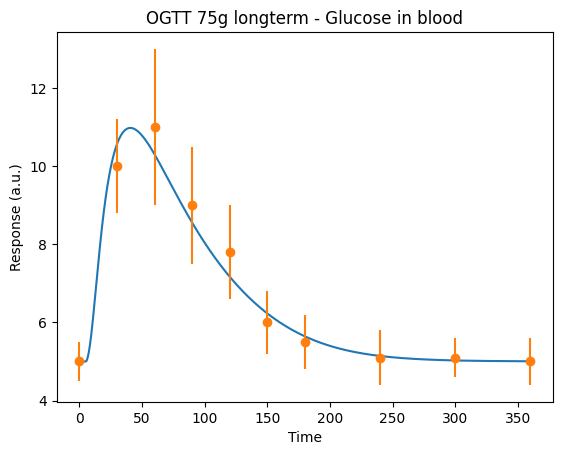

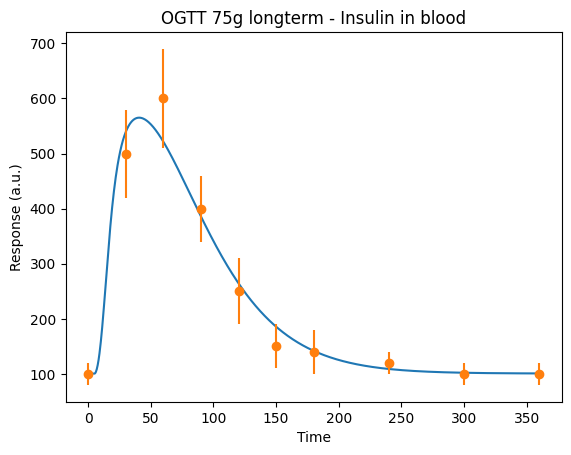

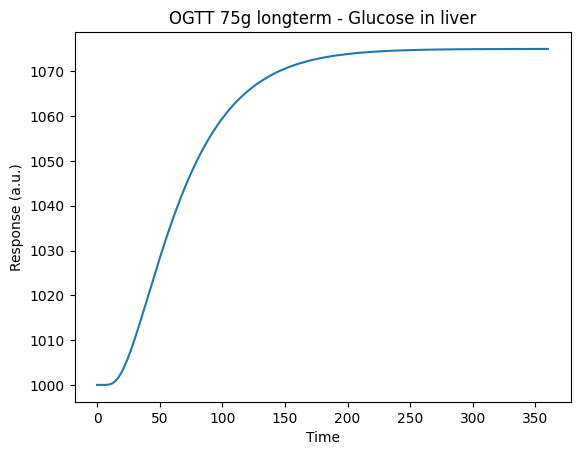

In [57]:
theta = [3.53579878e-02, 3.29095486e-02, 1.54614753e-04, 1.46740186e+05, 1.24116030e+03,
 1.73682833e+02, 6.88210529e-01, 1.56684206e+00,
 8.46759379e-01, 9.07592697e+00, 3.49757932e+00] # Known good solution
simulate_and_plot(sims_pancreas_liver_hill2, theta, data = DATA_LONGTERM)


## Making predictions
Now that we have a model which is acting reasonably, we can use it make predictions

### Estimating the increased insulin production in Type 2 diabetes

Now, we have this hypothetical scenario, where the person have partial insulin resistance (~50% less sensitivity). How much would you need to increase the insulin secretion to bring the glucose level down to normal amounts? Can you find any combinations of parameter values which give normal insulin levels? 

In [ ]:
k4_slider = widgets.FloatSlider(min=0.001, max=1e6, step=1, value=theta[3])
k4a_slider = widgets.FloatSlider(min=0.001, max=10000, step=1, value=theta[4])
kMglu_slider = widgets.FloatSlider(min=2, max=10, step=0.01, value=theta[9])
n_slider = widgets.FloatSlider(min=0.5, max=4, step=0.01, value=theta[10])

# Simulate and plot
@interact(k4=k4_slider, k4a=k4a_slider, kMglu=kMglu_slider, n=n_slider)
def handle_input(k4=0.1, k4a=100, kMglu=8.5, n=3.7):
    p = theta.copy()
    p[2] = p[2]/2
    p[3] = k4
    p[4] = k4a
    p[9] = kMglu
    p[10] = n
    
    simulate_and_plot(sims_pancreas_liver_hill2, p, data = DATA_LONGTERM)
    plt.show()

### Maintaining glucose levels with exercise

Given your manual selection to give improved glucose dynamics, can you improve the agreement by introducing exercise? Can you reduce the amount of insulin needed to be secreted? 

In [ ]:
# Setup simulations for the model which includes exercise
sund.installModel('models/pancreas_liver_exercise.txt')
Pancreas_liver_exercise = sund.importModel('pancreas_liver_exercise')
pancreas_liver_exercise = Pancreas_liver_exercise() # get the object from the model class

sims_pancreas_liver_exercise = {}
sims_pancreas_liver_exercise["OGTT 75g longterm"] = setup_simulation(pancreas_liver_exercise, glucose = DATA_LONGTERM["OGTT 75g longterm"]["input"]["glucose"])


In [52]:
theta_exercise = theta.copy()
theta_exercise[2] = theta_exercise[2]/2
theta_exercise[3] = k4_slider.value
theta_exercise[4] = k4a_slider.value
theta_exercise[9] = kMglu_slider.value
theta_exercise[10] = n_slider.value
theta_exercise.insert(-2, 0)

k4_slider_2 = widgets.FloatSlider(min=0.001, max=1e6, step=1, value=k4_slider.value)
k4a_slider_2 = widgets.FloatSlider(min=0.001, max=10000, step=1, value=k4a_slider.value)
kMglu_slider_2 = widgets.FloatSlider(min=2, max=10, step=0.01, value=kMglu_slider.value)
n_slider_2 = widgets.FloatSlider(min=0.5, max=4, step=0.01, value=n_slider.value)


exercise_slider = widgets.FloatSlider(min=0.0001, max=0.1, step=0.00001, value=0)

# Simulate and plot
@interact(k4=k4_slider_2, k4a=k4a_slider_2, kMglu=kMglu_slider_2, n=n_slider_2, exercise=exercise_slider)
def handle_input(k4=0.1, k4a=100, kMglu=8.5, n=3.7, exercise=0):
    p = theta_exercise.copy()
    p[3] = k4
    p[4] = k4a
    p[9] = kMglu
    p[10] = exercise
    p[11] = n
    
    simulate_and_plot(sims_pancreas_liver_exercise, p, data = DATA_LONGTERM)
    plt.show()

interactive(children=(FloatSlider(value=259644.001, description='k4', max=1000000.0, min=0.001, step=1.0), Flo…

### Simulating Type 1 diabetes

In type 1 diabetes, insulin production is severly decreased or fully stopped. We can simulate this scenario by setting the corresponding insulin secretion parameters to 0. 
Can exercise alone maintain the glucose levels? 

In [66]:
theta_exercise = theta.copy()
theta_exercise[3] = 0 
theta_exercise[4] = 0
theta_exercise.insert(-2, 0)

exercise_slider_2 = widgets.FloatSlider(min=0.0001, max=0.1, step=0.00001, value=0)

ic = pancreas_liver_exercise.statevalues.copy()
ic[-2] = 0

print(ic)
# Simulate and plot
@interact(exercise=exercise_slider)
def handle_input(exercise=0):
    p = theta_exercise.copy()
    p[10] = exercise
    
    simulate_and_plot(sims_pancreas_liver_exercise, p, ic=ic, data = DATA_LONGTERM)
    plt.show()

[   0.    0.    5.    0. 1000.]


interactive(children=(FloatSlider(value=0.055670000000000004, description='exercise', max=0.1, min=0.0001, ste…

### Simulating insulin doses in T1D
By adding insulin infusions to the model, we can now try to control the glucose levels.

In [ ]:
# Setup the IV model
sund.installModel('models/pancreas_liver_exercise_IV.txt')
Pancreas_liver_exercise_IV = sund.importModel('pancreas_liver_exercise_IV')
pancreas_liver_exercise_IV = Pancreas_liver_exercise_IV() # get the object from the model class

sims_pancreas_liver_exercise_IV = {}
sims_pancreas_liver_exercise_IV["OGTT 75g longterm"] = setup_simulation(pancreas_liver_exercise_IV, glucose = DATA_LONGTERM["OGTT 75g longterm"]["input"]["glucose"])
